<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt


In [ ]:
base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8




942080/935806 [==============================] - 0s 0us/step


In [ ]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size 
img_nrows = 400
img_ncols = int(width * img_nrows / height)


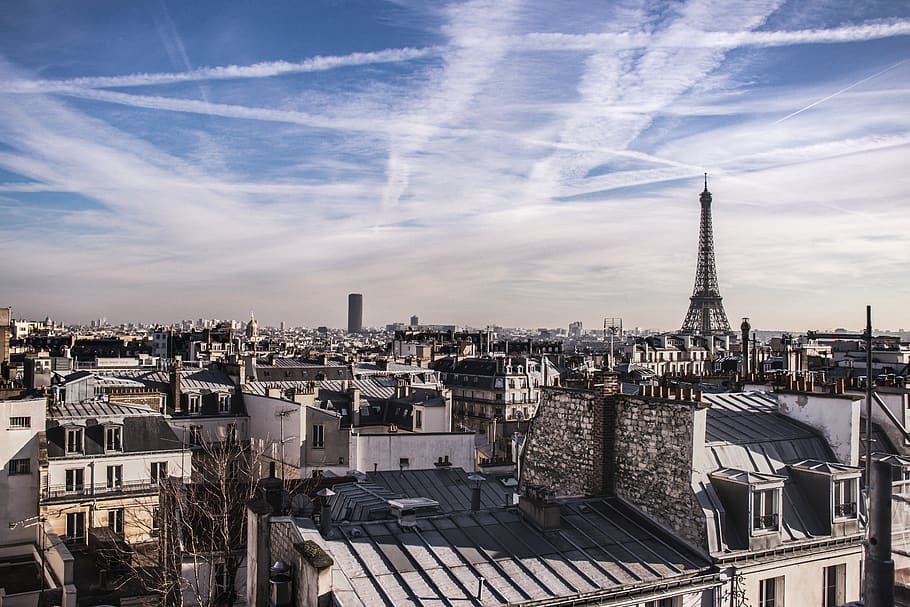

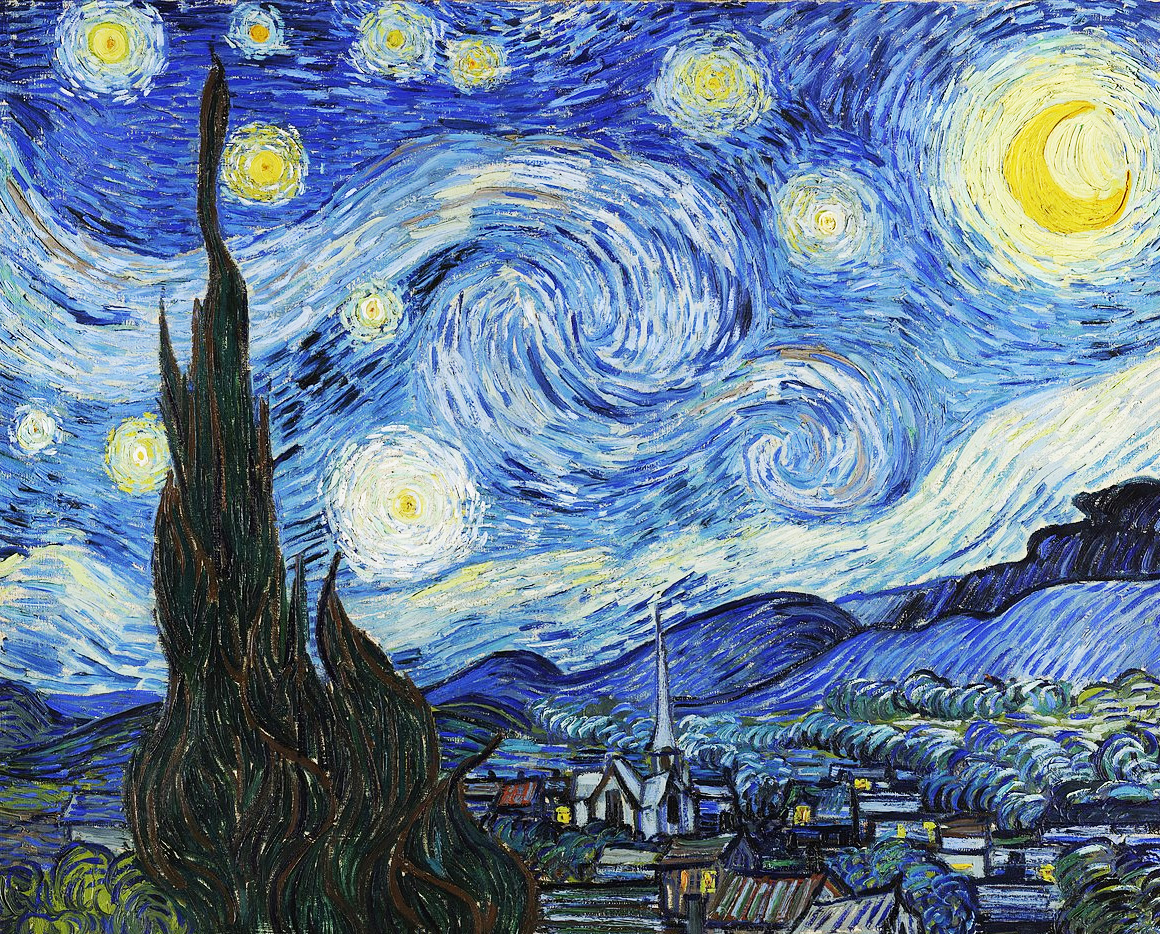

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:
def preprocess_image(image_path):
  # Util function to open, resize and format pictures into appropriate tensors
  img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
  img = keras.preprocessing.image.img_to_array(img)
  img = tf.expand_dims(img, axis= 0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)


def deprocess_image(x):
  # Util function to convert a tensor into a valid image
  x = x.reshape((img_nrows, img_ncols, 3))
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # 'BGR'->'RGB'
  x = x[:,:,::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x 

In [ ]:
tf.Variable(preprocess_image(base_image_path))

<tf.Variable 'Variable:0' shape=(1, 400, 599, 3) dtype=float32, numpy=
array([[[[ 22.060997 , -33.779    , -61.68     ],
         [ 21.060997 , -34.779    , -62.68     ],
         [ 21.060997 , -34.779    , -62.68     ],
         ...,
         [ 35.060997 , -14.778999 , -41.68     ],
         [ 36.060997 , -13.778999 , -40.68     ],
         [ 38.060997 , -11.778999 , -38.68     ]],

        [[ 25.060997 , -30.779    , -58.68     ],
         [ 24.060997 , -31.779    , -59.68     ],
         [ 24.060997 , -31.779    , -59.68     ],
         ...,
         [ 44.060997 ,  -8.778999 , -34.68     ],
         [ 46.060997 ,  -6.7789993, -32.68     ],
         [ 47.060997 ,  -5.7789993, -31.68     ]],

        [[ 26.060997 , -29.779    , -57.68     ],
         [ 26.060997 , -29.779    , -57.68     ],
         [ 25.060997 , -30.779    , -58.68     ],
         ...,
         [ 46.060997 ,  -6.7789993, -32.68     ],
         [ 48.060997 ,  -4.7789993, -30.68     ],
         [ 49.060997 ,  -3.778999

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


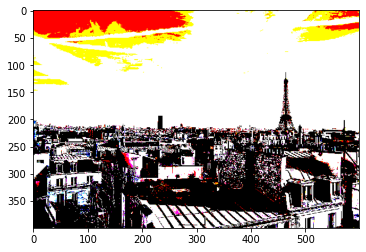

In [ ]:
plt.imshow(tf.squeeze(preprocess_image(base_image_path), axis=0))
base = np.squeeze(preprocess_image(base_image_path), axis= 0)

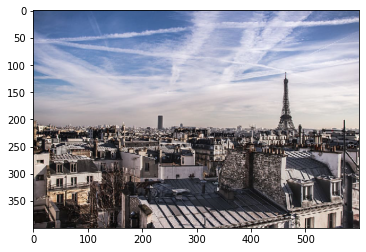

In [ ]:
plt.imshow(deprocess_image(base.numpy()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


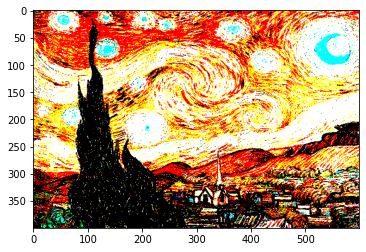

In [ ]:
plt.imshow(tf.squeeze(preprocess_image(style_reference_image_path), axis=0))
style = tf.squeeze(preprocess_image(style_reference_image_path), axis=0)

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, shape = (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


In [ ]:
a = gram_matrix(base)
b = gram_matrix(style)

In [ ]:
size = img_nrows * img_ncols
size

239600

In [ ]:
tf.reduce_sum(tf.square(a- b))

<tf.Tensor: shape=(), dtype=float32, numpy=1.2754457e+18>

In [ ]:
tf.square(a- b)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[3.6790260e+15, 9.3711376e+16, 5.1798701e+17],
       [9.3711376e+16, 6.4181884e+14, 2.3384018e+16],
       [5.1798701e+17, 2.3384018e+16, 9.6001223e+14]], dtype=float32)>

In [ ]:
channels = 3

channels ** 2

9

In [ ]:
(4.0 * (channels ** 2) * (size ** 2))

2066693760000.0

In [ ]:
tf.reduce_sum(tf.square(a- b)) /(4.0 * (channels ** 2) * (size ** 2))

<tf.Tensor: shape=(), dtype=float32, numpy=617143.06>

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights = 'imagenet', include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


In [ ]:
model.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]

In [ ]:
outputs_dict

{'block1_conv1': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 'block3_conv3': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 'block3

In [ ]:
base = preprocess_image(base_image_path)
style = preprocess_image(style_reference_image_path)
combination = tf.Variable(preprocess_image(base_image_path))

input_tensor = tf.concat(
        [base, style, combination], axis=0
    )



In [ ]:
base.shape

TensorShape([1, 400, 599, 3])

In [ ]:
input_tensor

<tf.Tensor: shape=(3, 400, 599, 3), dtype=float32, numpy=
array([[[[  22.060997 ,  -33.779    ,  -61.68     ],
         [  21.060997 ,  -34.779    ,  -62.68     ],
         [  21.060997 ,  -34.779    ,  -62.68     ],
         ...,
         [  35.060997 ,  -14.778999 ,  -41.68     ],
         [  36.060997 ,  -13.778999 ,  -40.68     ],
         [  38.060997 ,  -11.778999 ,  -38.68     ]],

        [[  25.060997 ,  -30.779    ,  -58.68     ],
         [  24.060997 ,  -31.779    ,  -59.68     ],
         [  24.060997 ,  -31.779    ,  -59.68     ],
         ...,
         [  44.060997 ,   -8.778999 ,  -34.68     ],
         [  46.060997 ,   -6.7789993,  -32.68     ],
         [  47.060997 ,   -5.7789993,  -31.68     ]],

        [[  26.060997 ,  -29.779    ,  -57.68     ],
         [  26.060997 ,  -29.779    ,  -57.68     ],
         [  25.060997 ,  -30.779    ,  -58.68     ],
         ...,
         [  46.060997 ,   -6.7789993,  -32.68     ],
         [  48.060997 ,   -4.7789993,  -30.68   

In [ ]:
features = feature_extractor(input_tensor)

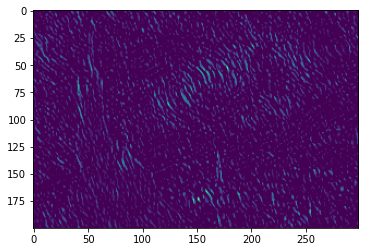

In [ ]:
plt.imshow(features["block2_conv2"][1][:, :, 5])

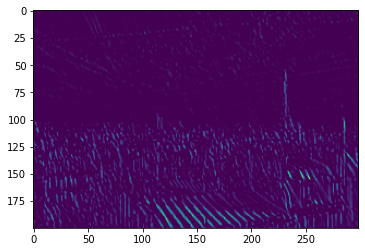

In [ ]:
plt.imshow(features["block2_conv2"][0][:, :, 5])

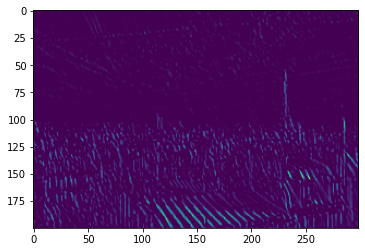

In [ ]:
plt.imshow(features["block2_conv2"][2][:, :, 5])

In [ ]:
features["block2_conv2"][0][:, :, :]

<tf.Tensor: shape=(200, 299, 128), dtype=float32, numpy=
array([[[ 12.680713, 295.53757 ,   9.019469, ...,   0.      ,
           0.      ,   0.      ],
        [ 81.129196,   0.      ,   0.      , ..., 160.00804 ,
           0.      ,   0.      ],
        [ 88.58487 ,   0.      ,   0.      , ...,  61.666794,
           0.      ,   0.      ],
        ...,
        [ 71.64069 , 121.48471 ,   0.      , ..., 164.30608 ,
           0.      ,   0.      ],
        [ 44.192818, 101.29519 ,   0.      , ..., 211.48544 ,
           0.      ,   0.      ],
        [102.10175 ,   0.      , 117.18397 , ..., 246.0846  ,
           0.      ,   0.      ]],

       [[  0.      , 138.40627 ,   0.      , ...,   0.      ,
         107.30175 ,   0.      ],
        [ 19.511127,   0.      ,   0.      , ..., 155.0011  ,
           0.      , 112.4396  ],
        [  0.      ,   0.      ,   0.      , ...,  45.85645 ,
           0.      ,  83.94958 ],
        ...,
        [ 30.57159 ,   0.      ,   0.      , ..., 1

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    #Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)

    # Add style loss
    for layer_name in style_layer_names:
      layer_features = features[layer_name]
      style_reference_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      s1 = style_loss(style_reference_features, combination_features)
      loss += (style_weight / len(style_layer_names)) * s1

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss 


In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_rate=0.96, decay_steps=100))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, combination_image)])

  if i % 100 ==0:
    print("Iteration %d: loss=%.2f" % (i, loss))
    img = deprocess_image(combination_image.numpy())
    fname = result_prefix + "_at_iteration_%d.png" % i
    keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=11018.22
Iteration 200: loss=8513.87
Iteration 300: loss=7571.45
Iteration 400: loss=7063.81
Iteration 500: loss=6735.92
Iteration 600: loss=6501.49
Iteration 700: loss=6323.05
Iteration 800: loss=6181.23
Iteration 900: loss=6065.17
Iteration 1000: loss=5967.56
Iteration 1100: loss=5884.51
Iteration 1200: loss=5812.84
Iteration 1300: loss=5750.48
Iteration 1400: loss=5695.77
Iteration 1500: loss=5647.34
Iteration 1600: loss=5604.24
Iteration 1700: loss=5565.54
Iteration 1800: loss=5530.73
Iteration 1900: loss=5499.19
Iteration 2000: loss=5470.50
Iteration 2100: loss=5444.35
Iteration 2200: loss=5420.38
Iteration 2300: loss=5398.41
Iteration 2400: loss=5378.21
Iteration 2500: loss=5359.60
Iteration 2600: loss=5342.41
Iteration 2700: loss=5326.48
Iteration 2800: loss=5311.68
Iteration 2900: loss=5297.94
Iteration 3000: loss=5285.12
Iteration 3100: loss=5273.18
Iteration 3200: loss=5262.00
Iteration 3300: loss=5251.52
Iteration 3400: loss=5241.71
Iteration 3500: loss=5

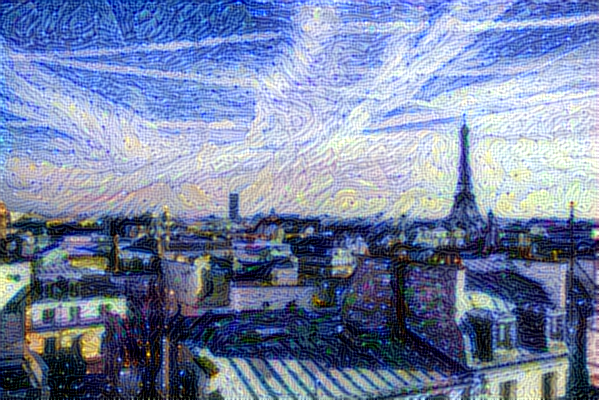

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))
